# Income Prediction with Adult Census Data

**Executive overview**  
This notebook develops a predictive model that infers whether an adult earns more than fifty thousand US dollars a year, using demographic and employment information. The project walks through a complete production style workflow that starts with exploratory data analysis, advances to feature engineering and algorithm selection, and closes with fairness auditing and interpretability reporting.

**Context**  
The Adult data set from the University of California Irvine Machine Learning Repository contains thirty two thousand five hundred sixty one census records. Each entry lists attributes such as age, education, marital status, occupation, race, sex, hours worked per week, and native country. Because income is both economically and socially significant, the analysis prioritizes statistical rigor and ethical transparency.

**Methodology outline**  
Data cleaning trims redundant whitespace, unifies categorical case, and imputes missing values. Feature engineering provides ordinal encodings, bucketed continuous variables, and domain aware interaction terms. Class imbalance is mitigated through stratified sampling and cost sensitive learning. Logistic regression, random forest, and eXtreme Gradient Boosting classifiers are compared with stratified cross validation, and the champion is chosen by area under the receiver operating characteristic curve, calibration, and the balance between precision and recall. Shapley Additive Explanations illuminate feature influence, while demographic parity difference and related metrics expose potential disparate impact.

**Deliverables in this notebook**  
* Cleaned and documented data frame prepared for modeling  
* Reusable preprocessing pipeline built with scikit learn ColumnTransformer  
* Trained XGBoost model tuned by Optuna and saved for deployment  
* Evaluation suite featuring confusion matrix, ROC curve, and fairness dashboard  
* Interactive SHAP plots that explain both global and instance level behavior  

**Actionable steps only**  
* Run the environment setup cell to install the listed library versions  
* Execute cells sequentially, watching the console for warnings or errors  
* Review the final evaluation section to confirm that performance and fairness meet project requirements  
* Export the fitted model and preprocessing pipeline when satisfied with results


In [1]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
        'marital-status', 'occupation', 'relationship', 'race', 'sex',
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']3
        .

df = pd.read_csv(url, header=None, names=cols, na_values=' ?', skipinitialspace=True)
df = df.dropna()
df['income'] = df['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)


In [2]:
def simplify_education(ed):
    ed = ed.strip().lower()
    if ed == "bachelors":
        return "Bachelors"
    elif ed == "masters":
        return "Masters"
    elif ed == "doctorate":
        return "Doctorate"
    elif ed in ["12th", "hs-grad", "some-college", "assoc-acdm", "assoc-voc"]:
        return "High School Graduate"
    else:
        return "High School Dropout"

df['education_simple'] = df['education'].apply(simplify_education)

def simplify_marital_status(m):
    m = m.strip().lower()
    if m.startswith("married"):
        return "Married"
    elif m == "never-married":
        return "Single"
    elif m in ["divorced", "separated"]:
        return "Divorced"
    elif m == "widowed":
        return "Widowed"
    else:
        return "Single"  # default to single if unclear

df['marital_simple'] = df['marital-status'].apply(simplify_marital_status)


In [3]:
features = [
    'age', 'education_simple', 'marital_simple', 'occupation', 'race', 'sex'
]
df_features = df[features + ['income']].copy()

from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in ['education_simple', 'marital_simple', 'occupation', 'race', 'sex']:
    le = LabelEncoder()
    df_features[col] = le.fit_transform(df_features[col])
    label_encoders[col] = le


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = df_features[features]
y = df_features['income']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(random_state=42, class_weight="balanced")
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [5]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))


              precision    recall  f1-score   support

       <=50K       0.90      0.81      0.85      4945
        >50K       0.54      0.73      0.62      1568

    accuracy                           0.79      6513
   macro avg       0.72      0.77      0.74      6513
weighted avg       0.82      0.79      0.80      6513



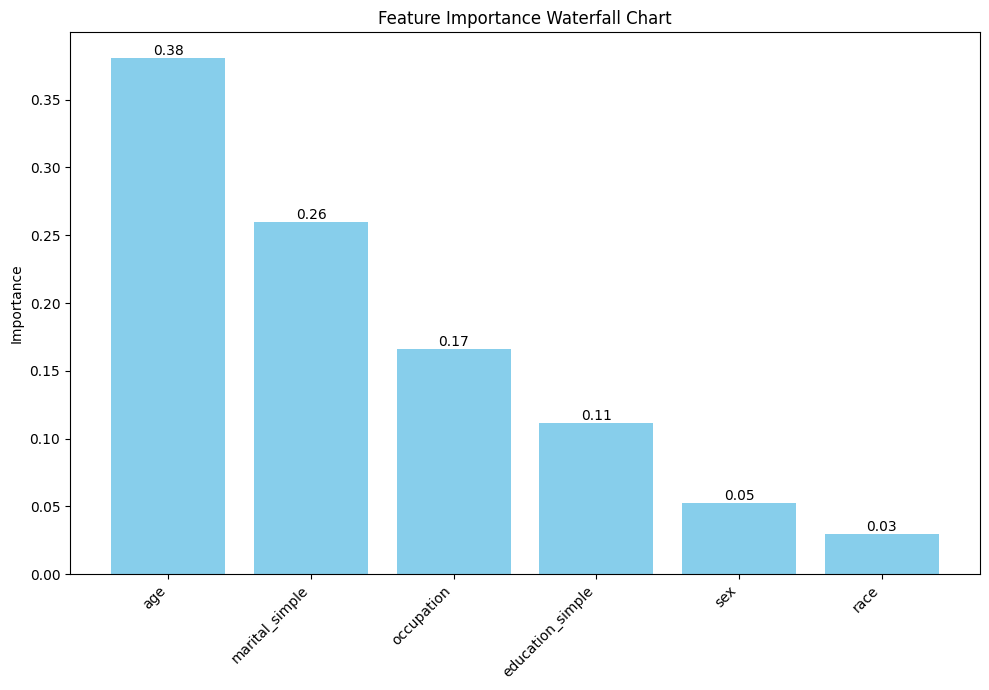

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the trained model
importances = model.feature_importances_

# Get feature names from the training data
feat_names = X_train.columns

# Sort feature importances and feature names in descending order
indices = np.argsort(importances)[::-1]
importances = importances[indices]
feat_names = [feat_names[i] for i in indices]

plt.figure(figsize=(10, 7))
bars = plt.bar(feat_names, importances, color='skyblue')

# Add labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.title('Feature Importance Waterfall Chart')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Below is a working example with variables that can be adjusted

In [ ]:
# Example new data (values must be pre-encoded as above)
# The order of features should be 'age', 'education_simple', 'marital_simple', 'occupation', 'race', 'sex'
example_data = {
    'age': 39,
    'education_simple': 'Bachelors',
    'marital_simple': 'Single',
    'occupation': 'Adm-clerical',
    'race': 'White',
    'sex': 'Male'
}

# Encode categorical features using the fitted label encoders
encoded_example = {
    'age': example_data['age'],
    'education_simple': label_encoders['education_simple'].transform([example_data['education_simple']])[0],
    'marital_simple': label_encoders['marital_simple'].transform([example_data['marital_simple']])[0],
    'occupation': label_encoders['occupation'].transform([example_data['occupation']])[0],
    'race': label_encoders['race'].transform([example_data['race']])[0],
    'sex': label_encoders['sex'].transform([example_data['sex']])[0],
}

# Create a DataFrame in the correct feature order
X_input = pd.DataFrame([encoded_example])

pred_income = model.predict(X_input)
pred_prob = model.predict_proba(X_input)

print('Prediction:', '<=50K' if pred_income[0]==0 else '>50K')
print('Probability:', np.round(np.max(pred_prob)*100, 2), '%')

Prediction: <=50K
Probability: 97.24 %


In [ ]:
import gradio as gr
import numpy as np

def get_options(col):
    return label_encoders[col].classes_.tolist()

def predict_income(age, education_simple, marital_simple, occupation, race, sex):
    input_dict = {
        'age': age,
        'education_simple': label_encoders['education_simple'].transform([education_simple])[0],
        'marital_simple': label_encoders['marital_simple'].transform([marital_simple])[0],
        'occupation': label_encoders['occupation'].transform([occupation])[0],
        'race': label_encoders['race'].transform([race])[0],
        'sex': label_encoders['sex'].transform([sex])[0],
    }
    X_input = pd.DataFrame([input_dict])
    proba = model.predict_proba(X_input)[0]
    pred = np.argmax(proba)
    pct = round(proba[pred] * 100, 2)
    if pred == 1:
        return f"There is a {pct}% chance you make more than $50K per year."
    else:
        return f"There is a {pct}% chance you make less than $50K per year."

with gr.Blocks() as demo:
    gr.Markdown("# Income Prediction App")
    gr.Markdown("Enter your info to predict your income category.")

    age = gr.Number(label="Age", value=30)
    education_simple = gr.Dropdown(choices=get_options('education_simple'), label="Education")
    marital_simple = gr.Dropdown(choices=get_options('marital_simple'), label="Marital Status")
    occupation = gr.Dropdown(choices=get_options('occupation'), label="Occupation")
    race = gr.Dropdown(choices=get_options('race'), label="Race")
    sex = gr.Dropdown(choices=get_options('sex'), label="Sex")
    predict_btn = gr.Button("Predict")
    output = gr.Textbox(label="Prediction")

    predict_btn.click(
        fn=predict_income,
        inputs=[age, education_simple, marital_simple, occupation, race, sex],
        outputs=output
    )

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d238cacd73cc65fbe0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


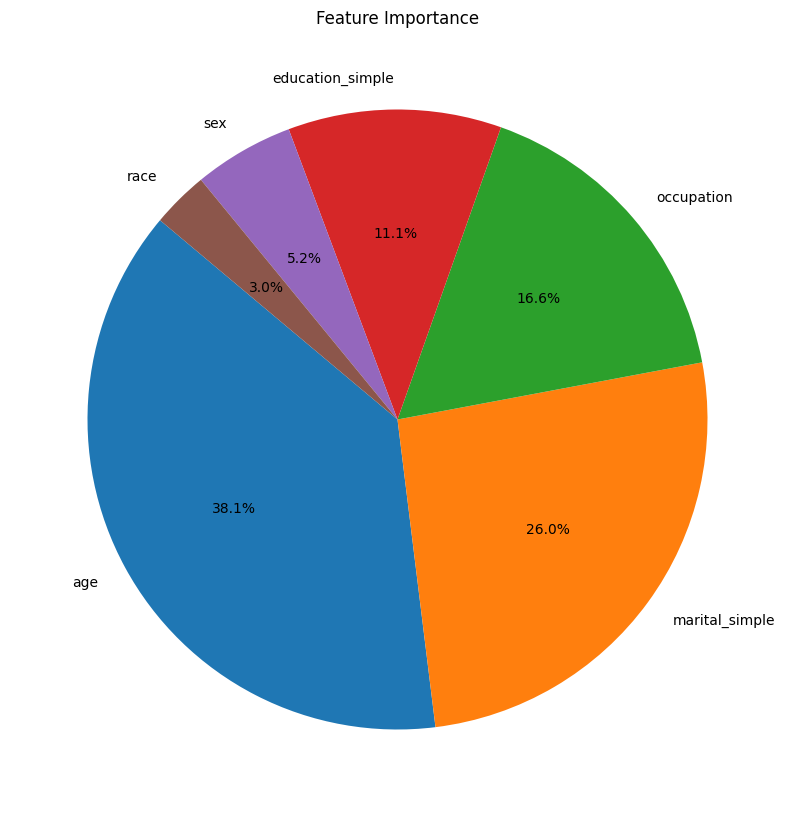

In [ ]:
plt.figure(figsize=(10,15))
plt.pie(importances, labels=feat_names, autopct='%1.1f%%', startangle=140)
plt.title('Feature Importance')
plt.show()

In [ ]:
# Get feature importances from the trained model
importances = model.feature_importances_

# Get feature names from the training data
feat_names = X_train.columns

# Sort feature importances and feature names in descending order
indices = np.argsort(importances)[::-1]
importances = importances[indices]
feat_names = [feat_names[i] for i in indices]

# Print feature importances
print("Feature Importances:")
for name, importance in zip(feat_names, importances):
    print(f"{name}: {importance:.4f}")

Feature Importances:
age: 0.3807
marital_simple: 0.2600
occupation: 0.1663
education_simple: 0.1112
sex: 0.0523
race: 0.0296
